In [85]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 8.6 gigabytes of available RAM



In [86]:
!pip install imbalanced-learn

from imblearn.over_sampling import SMOTE

def balance(X_temp, y_temp):
  smote = SMOTE()
  X_temp, y_temp= smote.fit_resample(X_temp, y_temp)
  return pd.concat([pd.DataFrame(X_temp), pd.DataFrame(y_temp)], axis=1)

In [87]:
from joblib import Parallel, delayed
import joblib
  

def save_model(model,model_name):
 joblib.dump(model, model_name)
  
def load_model(model_name):
  return joblib.load(model_name)

In [88]:
!pip install shap
import shap
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import cross_val_score

def explain_shap(model,temp_X,max_dis=20):
  explainer = shap.Explainer(model.predict, temp_X)
  shap_values = explainer (temp_X)
  shap.plots.bar(shap_values,max_display=max_dis)




def pred_dataframe(temp_y,temp_pred):
  return pd.DataFrame(
        {
            "Actual Value":temp_y,
            "Predicted Value":temp_pred,
            "Difference":temp_y-temp_pred
        })




def reg_plot(pred_y_df,width,height):
  sns.set(rc={'figure.figsize':(width,height)})
  sns.regplot(x="Actual Value", y="Predicted Value", data=pred_y_df)



# Confusion

In [89]:
def confusion_details(y_test,y_pred):
    labels = list(set(y_test))
    labels.sort()

    print("Total labels: %s -> %s" % (len(labels), labels))

    df = pd.DataFrame(
        data=confusion_matrix(y_test, y_pred, labels=labels),
        columns=labels,
        index=labels
    )

    print(df)

    print()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")
    print()
    #
    # Local (metrics per class)
    #
    tps = {}
    fps = {}
    fns = {}
    tns = {}

    precision_local = {}
    recall_local = {}
    f1_local = {}
    accuracy_local = {}
    specificity_local={}

    for label in labels:
        tps[label] = df.loc[label, label]
        fps[label] = df[label].sum() - tps[label]
        fns[label] = df.loc[label].sum() - tps[label]
        tns[label]=len(y_test) - (tps[label] + fps[label] + fns[label])
        
        tp, fp, fn, tn = tps[label], fps[label], fns[label], tns[label]
        
        precision_local[label] = tp / (tp + fp) if (tp + fp) > 0. else 0.
        specificity_local[label] = tn / (tn + fp) if (tn + fp) > 0. else 0.
        recall_local[label] = tp / (tp + fn) if (tp + fp) > 0. else 0.
        p, r = precision_local[label], recall_local[label]
        
        f1_local[label] = 2. * p * r / (p + r) if (p + r) > 0. else 0.
        accuracy_local[label] = tp / (tp + fp + fn) if (tp + fp + fn) > 0. else 0.



    print("#-- Local measures --#")
    print("True Positives(TP):", tps)
    print("False Positives(FP):", fps)
    print("True Negatives(TN):", tns)
    print("False Negatives(FN):", fns)
    print("----------------------------")

    print("Precision:", precision_local)
    print("Recall/Sensitivity:", recall_local)
    print("Specificity:",specificity_local)
    print("F1-Score:", f1_local)
    print("Accuracy:", accuracy_local)


    print()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")
    print()
    #
    # Global
    #
    micro_averages = {}
    macro_averages = {}

    correct_predictions = sum(tps.values())
    true_negative=sum(tns.values())

    den = sum(list(tps.values()) + list(fps.values()))
    micro_averages["Precision"] = 1. * correct_predictions / den if den > 0. else 0.

    den = sum(list(tps.values()) + list(fns.values()))
    micro_averages["Recall"] = 1. * correct_predictions / den if den > 0. else 0.

    den = sum(list(tns.values()) + list(fps.values()))
    micro_averages["Specificity"] = 1. * true_negative / den if den > 0. else 0.


    micro_avg_p, micro_avg_r = micro_averages["Precision"], micro_averages["Recall"]
    micro_averages["F1-score"] = 2. * micro_avg_p * micro_avg_r / (micro_avg_p + micro_avg_r) if (micro_avg_p + micro_avg_r) > 0. else 0.

    macro_averages["Precision"] = np.mean(list(precision_local.values()))
    macro_averages["Recall"] = np.mean(list(recall_local.values()))
    macro_averages["Specificity"]=np.mean(list(specificity_local.values()))


    macro_avg_p, macro_avg_r = macro_averages["Precision"], macro_averages["Recall"]
    macro_averages["F1-Score"] = 2. * macro_avg_p * macro_avg_r / (macro_avg_p + macro_avg_r) if (macro_avg_p + macro_avg_r) > 0. else 0.

    total_predictions = df.values.sum()
    accuracy_global = correct_predictions / total_predictions if total_predictions > 0. else 0.

    print("#-- Global measures --#")
    print("Micro-Averages:", micro_averages)
    print("Macro-Averages:", macro_averages)
    print("Correct predictions:", correct_predictions)
    print("Total predictions:", total_predictions)
    print("Accuracy:", accuracy_global)


    print()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")
    print()



    accuracy_local_new = {}
    for label in labels:
        tp, fp, fn, tn = tps[label], fps[label], fns[label], tns[label]
        accuracy_local_new[label] = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0. else 0.

    total_true = sum(list(tps.values()) + list(tns.values()))
    total_predictions = sum(list(tps.values()) + list(tns.values()) + list(fps.values()) + list(fns.values()))
    accuracy_global_new = 1. * total_true / total_predictions if total_predictions > 0. else 0.

    print("Accuracy (per class), with TNs:", accuracy_local_new)
    print("Accuracy (per class), without TNs:", accuracy_local)
    print("Accuracy (global), with TNs:", accuracy_global_new)
    print("Accuracy (global), without TNs:", accuracy_global)

In [90]:
!pip install seaborn
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def Con_Mat(y_test,y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize = (15,10))
  sn.heatmap(cm, annot=True, fmt='d',linewidth=.5) # here, cm is called to be visualized
  plt.xlabel('Predicted',fontsize=14.0, fontweight='bold')
  plt.ylabel('Truth',fontsize=12.0, fontweight='bold')

In [91]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def Accurecy_Details(y_test,y_pred):    
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test,y_pred))
  print("Accurecy: ",accuracy_score(y_test, y_pred))

# ROC

In [92]:
def ROC(y_score,cls):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(cls)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Plot ROC curve
    plt.figure(figsize = (10,7))
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                  ''.format(roc_auc["micro"]))
    for i in range(len(cls)):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                      ''.format(cls[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

# Main Code

In [93]:
import numpy as np
import pandas as pd
from tqdm import tqdm

dataset=pd.read_csv("https://raw.githubusercontent.com/RafsanJany-44/Research_5_Sleep_Stages_Classification/main/DATA/EEG_Five_Stages_HMC.csv")


target="Sleep_Stage"

classes = np.array(sorted(list(set(dataset[target]))))

In [94]:
dataset.head()

,Sleep_Stage,MeanP_Alpha_F4,MedianF_Alpha_F4,MeanF_Alpha_F4,Spectral Edge_Alpha_F4,PeakF_Alpha_F4,MeanP_Beta_F4,MedianF_Beta_F4,MeanF_Beta_F4,Spectral Edge_Beta_F4,...,MeanP_Delta_O2,MedianF_Delta_O2,MeanF_Delta_O2,Spectral Edge_Delta_O2,PeakF_Delta_O2,MeanP_Gamma_O2,MedianF_Gamma_O2,MeanF_Gamma_O2,Spectral Edge_Gamma_O2,PeakF_Gamma_O2
0,W,0.00051,8.74146,18.48195,17.48293,8.24195,0.00071,19.73073,29.84585,33.84195,...,0.00724,0.74927,3.87122,1.99805,0.87415,0.000210,35.21561,42.20878,49.95122,49.95122
1,W,0.00040,10.24000,17.48293,16.85854,10.61463,0.00051,17.23317,26.34927,29.34634,...,0.00723,0.49951,3.74634,1.24878,0.49951,0.000095,34.34146,43.33268,49.95122,49.95122
2,W,0.00036,9.74049,17.98244,17.48293,8.74146,0.00047,17.60780,25.47512,28.22244,...,0.00230,0.62439,5.24488,2.12293,0.62439,0.000074,34.59122,45.95512,49.95122,49.95122
3,W,0.00035,10.11512,17.60780,17.10829,9.61561,0.00047,17.35805,26.47415,28.72195,...,0.00091,0.87415,6.61854,3.12195,0.62439,0.000082,32.46829,43.95707,49.95122,49.95122
4,W,0.00033,9.74049,17.60780,17.23317,8.11707,0.00043,17.23317,25.84976,28.09756,...,0.00175,0.49951,5.74439,2.24780,0.49951,0.000077,33.59220,44.83122,49.95122,49.95122


In [95]:

print("-------------------Before-------------------------")
set(list(dataset[target]))
frequency = dataset["Sleep_Stage"].value_counts()
print(frequency)


from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
dataset[target]=encoder.fit_transform(dataset[target])


print("--------------------After--------------------------")
set(list(dataset[target]))
frequency = dataset["Sleep_Stage"].value_counts()
print(frequency)

-------------------Before-------------------------
N2    39428
N3    21290
W     19355
R     16465
N1    11913
Name: Sleep_Stage, dtype: int64
--------------------After--------------------------
1    39428
2    21290
4    19355
3    16465
0    11913
Name: Sleep_Stage, dtype: int64


In [96]:
X = dataset.loc[:, dataset.columns!=target]
y = dataset[target]



In [97]:
"""from sklearn.preprocessing import label_binarize
cls=["N1", "N2","N3","R","W"]
y = label_binarize(y, classes=cls)"""

'from sklearn.preprocessing import label_binarize\ncls=["N1", "N2","N3","R","W"]\ny = label_binarize(y, classes=cls)'

In [98]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)


In [99]:

#print("----------------------before------------------")
#frequency = y_train.value_counts()
#print(frequency)


#new_dataset=balance(X_train,y_train)

#X_train = new_dataset.loc[:, new_dataset.columns!=target]
#y_train = new_dataset[target]


#print("----------------------After------------------")
#frequency = y_train.value_counts()
#print(frequency)

# XGBoost

In [100]:
xg = load_model("XGBClassifier(n_estimators=8000,max_depth=14,random_state=0)")




In [101]:

y_pred=xg.predict(X_test)
Accurecy_Details(y_test, y_pred)

[[1113  536   10  247  462]
 [ 440 6662  408  243  138]
 [  70  587 3574    6   17]
 [ 192  216   14 2897   55]
 [ 310   64    3   26 3401]]
              precision    recall  f1-score   support

           0       0.52      0.47      0.50      2368
           1       0.83      0.84      0.84      7891
           2       0.89      0.84      0.87      4254
           3       0.85      0.86      0.85      3374
           4       0.84      0.89      0.86      3804

    accuracy                           0.81     21691
   macro avg       0.78      0.78      0.78     21691
weighted avg       0.81      0.81      0.81     21691

Accurecy:  0.8135632289889816


In [102]:
confusion_details(y_test, y_pred)

Total labels: 5 -> [0, 1, 2, 3, 4]
      0     1     2     3     4
0  1113   536    10   247   462
1   440  6662   408   243   138
2    70   587  3574     6    17
3   192   216    14  2897    55
4   310    64     3    26  3401

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

#-- Local measures --#
True Positives(TP): {0: 1113, 1: 6662, 2: 3574, 3: 2897, 4: 3401}
False Positives(FP): {0: 1012, 1: 1403, 2: 435, 3: 522, 4: 672}
True Negatives(TN): {0: 18311, 1: 12397, 2: 17002, 3: 17795, 4: 17215}
False Negatives(FN): {0: 1255, 1: 1229, 2: 680, 3: 477, 4: 403}
----------------------------
Precision: {0: 0.5237647058823529, 1: 0.8260384376937384, 2: 0.8914941381890746, 3: 0.8473237788827143, 4: 0.8350110483672968}
Recall/Sensitivity: {0: 0.4700168918918919, 1: 0.8442529463946268, 2: 0.840150446638458, 3: 0.8586247777119146, 4: 0.8940588853838065}
Specificity: {

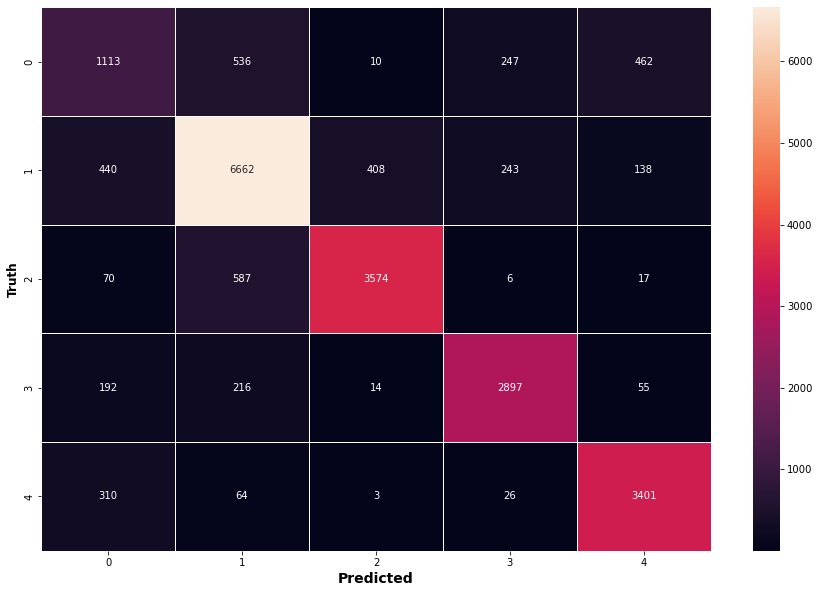

In [103]:
Con_Mat(y_test,y_pred)

Permutation explainer: 101it [3:23:36, 122.16s/it]                                                  


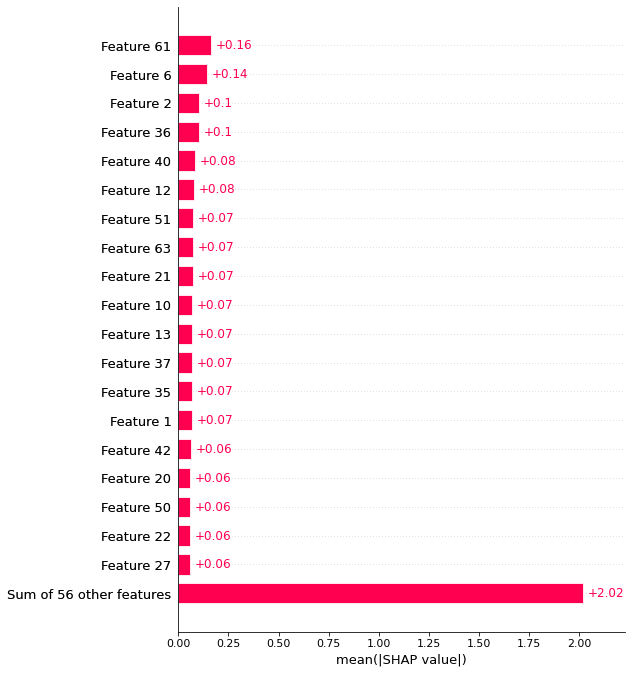

In [114]:
explain_shap(xg,X_test.values[0:100],20)

# GradientBoosting


In [104]:
gb = load_model("GradientBoostingClassifier(max_depth=14, n_estimators=4500)")


In [105]:

y_pred=gb.predict(X_test)
Accurecy_Details(y_test, y_pred)

[[1108  526    7  258  469]
 [ 401 6654  428  244  164]
 [  63  615 3549    6   21]
 [ 183  229    9 2884   69]
 [ 283   71    6   22 3422]]
              precision    recall  f1-score   support

           0       0.54      0.47      0.50      2368
           1       0.82      0.84      0.83      7891
           2       0.89      0.83      0.86      4254
           3       0.84      0.85      0.85      3374
           4       0.83      0.90      0.86      3804

    accuracy                           0.81     21691
   macro avg       0.78      0.78      0.78     21691
weighted avg       0.81      0.81      0.81     21691

Accurecy:  0.8121801668894933


In [106]:
confusion_details(y_test, y_pred)

Total labels: 5 -> [0, 1, 2, 3, 4]
      0     1     2     3     4
0  1108   526     7   258   469
1   401  6654   428   244   164
2    63   615  3549     6    21
3   183   229     9  2884    69
4   283    71     6    22  3422

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

#-- Local measures --#
True Positives(TP): {0: 1108, 1: 6654, 2: 3549, 3: 2884, 4: 3422}
False Positives(FP): {0: 930, 1: 1441, 2: 450, 3: 530, 4: 723}
True Negatives(TN): {0: 18393, 1: 12359, 2: 16987, 3: 17787, 4: 17164}
False Negatives(FN): {0: 1260, 1: 1237, 2: 705, 3: 490, 4: 382}
----------------------------
Precision: {0: 0.5436702649656526, 1: 0.8219888820259419, 2: 0.8874718679669917, 3: 0.8447568834212068, 4: 0.8255729794933655}
Recall/Sensitivity: {0: 0.46790540540540543, 1: 0.8432391331897098, 2: 0.8342736248236954, 3: 0.8547717842323651, 4: 0.8995793901156677}
Specificity: 

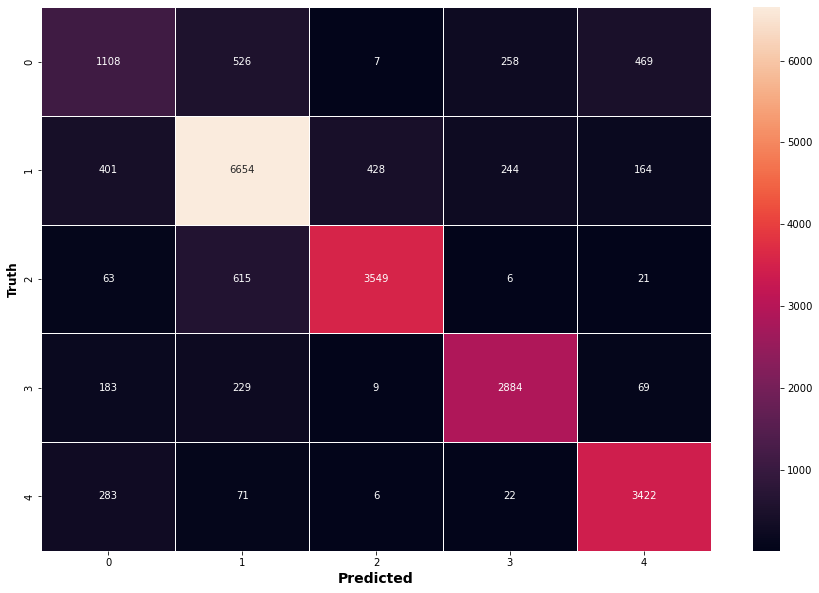

In [107]:
Con_Mat(y_test,y_pred)

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer:   1%|▍                                               | 1/100 [00:00<?, ?it/s]X does not have va

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer:   9%|███▍                                  | 9/100 [10:52<1:57:19, 77.36s/it]X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have va

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer:  17%|██████▎                              | 17/100 [21:48<1:54:55, 83.08s/it]X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have va

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer:  25%|█████████▎                           | 25/100 [32:29<1:42:22, 81.90s/it]X does not have va

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer:  32%|███████████▊                         | 32/100 [42:40<1:36:35, 85.23s/it]X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have va

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer:  40%|██████████████▊                      | 40/100 [54:16<1:28:01, 88.03s/it]X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have va

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer:  48%|████████████████▊                  | 48/100 [1:05:11<1:11:55, 82.98s/it]X does not have va

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer:  55%|███████████████████▎               | 55/100 [1:16:37<1:11:07, 94.83s/it]X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have va

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer:  63%|█████████████████████▍            | 63/100 [1:30:05<1:02:59, 102.14s/it]X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have va

Permutation explainer:  70%|█████████████████████████▏          | 70/100 [1:42:28<51:19, 102.64s/it]X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have va

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer:  78%|████████████████████████████        | 78/100 [1:57:16<39:50, 108.67s/it]X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have va

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer:  86%|███████████████████████████████▊     | 86/100 [2:10:18<23:01, 98.68s/it]X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have va

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer:  93%|██████████████████████████████████▍  | 93/100 [2:21:38<11:24, 97.85s/it]X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have va

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Permutation explainer: 101it [2:34:57, 92.98s/it]                                                   


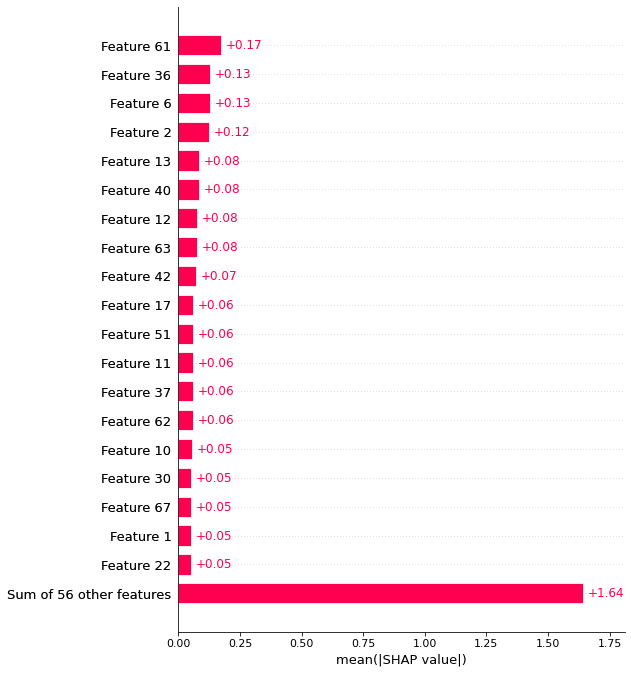

In [113]:
explain_shap(gb,X_test.values[0:100],20)

# Random Forest

In [115]:
rf = load_model("RandomForestClassifier(max_depth=49, random_state=0)")

In [116]:

y_pred=xg.predict(X_test)
Accurecy_Details(y_test, y_pred)

[[1113  536   10  247  462]
 [ 440 6662  408  243  138]
 [  70  587 3574    6   17]
 [ 192  216   14 2897   55]
 [ 310   64    3   26 3401]]
              precision    recall  f1-score   support

           0       0.52      0.47      0.50      2368
           1       0.83      0.84      0.84      7891
           2       0.89      0.84      0.87      4254
           3       0.85      0.86      0.85      3374
           4       0.84      0.89      0.86      3804

    accuracy                           0.81     21691
   macro avg       0.78      0.78      0.78     21691
weighted avg       0.81      0.81      0.81     21691

Accurecy:  0.8135632289889816


In [117]:
confusion_details(y_test, y_pred)

Total labels: 5 -> [0, 1, 2, 3, 4]
      0     1     2     3     4
0  1113   536    10   247   462
1   440  6662   408   243   138
2    70   587  3574     6    17
3   192   216    14  2897    55
4   310    64     3    26  3401

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

#-- Local measures --#
True Positives(TP): {0: 1113, 1: 6662, 2: 3574, 3: 2897, 4: 3401}
False Positives(FP): {0: 1012, 1: 1403, 2: 435, 3: 522, 4: 672}
True Negatives(TN): {0: 18311, 1: 12397, 2: 17002, 3: 17795, 4: 17215}
False Negatives(FN): {0: 1255, 1: 1229, 2: 680, 3: 477, 4: 403}
----------------------------
Precision: {0: 0.5237647058823529, 1: 0.8260384376937384, 2: 0.8914941381890746, 3: 0.8473237788827143, 4: 0.8350110483672968}
Recall/Sensitivity: {0: 0.4700168918918919, 1: 0.8442529463946268, 2: 0.840150446638458, 3: 0.8586247777119146, 4: 0.8940588853838065}
Specificity: {

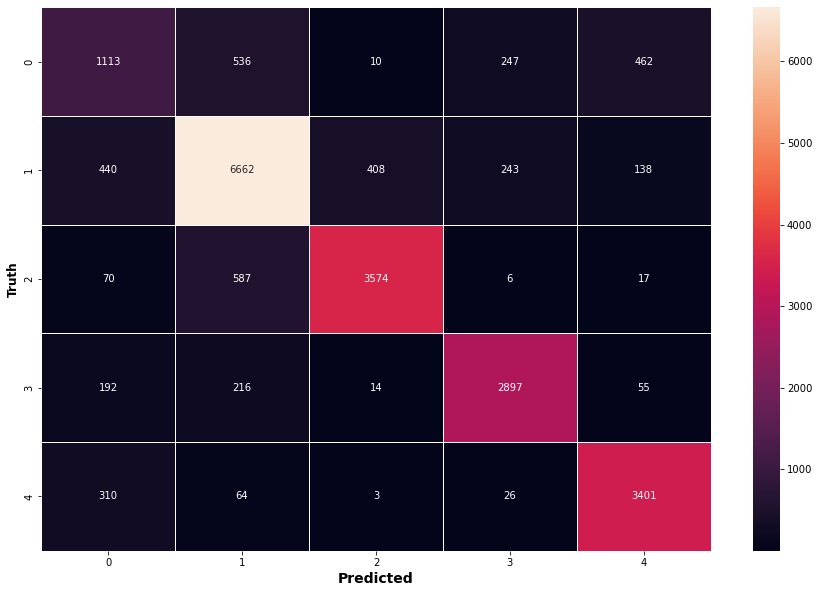

In [118]:
Con_Mat(y_test,y_pred)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Permutation explainer:  10%|███▉                                   | 10/100 [00:29<04:00,  2.68s/it]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestC

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Permutation explainer:  18%|███████                                | 18/100 [00:48<03:20,  2.45s/it]X does not have valid feature names, but RandomForestC

Permutation explainer:  25%|█████████▊                             | 25/100 [01:06<03:10,  2.54s/it]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestC

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Permutation explainer:  33%|████████████▊                          | 33/100 [01:26<02:47,  2.50s/it]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestC

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Permutation explainer:  41%|███████████████▉                       | 41/100 [01:46<02:25,  2.46s/it]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestC

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Permutation explainer:  49%|███████████████████                    | 49/100 [02:06<02:10,  2.55s/it]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestC

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Permutation explainer:  57%|██████████████████████▏                | 57/100 [02:26<01:46,  2.48s/it]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestC

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Permutation explainer:  65%|█████████████████████████▎             | 65/100 [02:46<01:27,  2.50s/it]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestC

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Permutation explainer:  73%|████████████████████████████▍          | 73/100 [03:07<01:09,  2.57s/it]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestC

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Permutation explainer:  81%|███████████████████████████████▌       | 81/100 [03:27<00:47,  2.52s/it]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestC

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Permutation explainer:  89%|██████████████████████████████████▋    | 89/100 [03:46<00:27,  2.47s/it]X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestC

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Permutation explainer:  97%|█████████████████████████████████████▊ | 97/100 [04:11<00:09,  3.23s/it]X does not have valid feature names, but RandomForestC

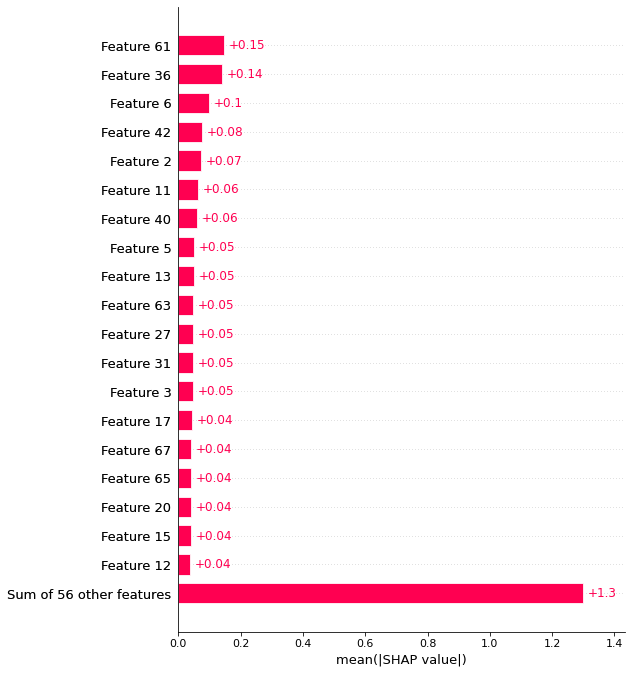

In [119]:
explain_shap(rf,X_test.values[0:100],20)